# House price analysis

## Setup

In [243]:
# This takes a long time / hangs, so don't do it unless we need to.
!pip install -Uq pandas kaggle fastai scikit-learn waterfallcharts treeinterpreter dtreeviz

In [244]:
import pandas as pd
import numpy as np
import os, zipfile
from fastai import * 
from fastai.tabular.all import *
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import *
from dtreeviz.trees import *
import graphviz
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [245]:
creds = '{"username":"divodivenson","key":"f0f9e3f8378e39e818097a5df978aa64"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [246]:
from kaggle import api
comp = 'house-prices-advanced-regression-techniques'
path = Path(f'../input/{comp}')
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#4) [Path('../input/house-prices-advanced-regression-techniques/test.csv'),Path('../input/house-prices-advanced-regression-techniques/data_description.txt'),Path('../input/house-prices-advanced-regression-techniques/train.csv'),Path('../input/house-prices-advanced-regression-techniques/sample_submission.csv')]

## First look at data


In [247]:
trn_path = path/'train.csv'
df = pd.read_csv(trn_path, low_memory=False)

df_test = pd.read_csv(path/'test.csv', low_memory=False)

len(df.columns), len(df_test.columns)

(81, 80)

In [248]:
# Lets get an idea of where the ordianls are
df.columns.map(lambda col: df[col].unique().size )

Index([1460,   15,    5,  111, 1073,    2,    3,    4,    4,    2,    5,    3,
         25,    9,    8,    5,    8,   10,    9,  112,   61,    6,    8,   15,
         16,    4,  328,    4,    5,    6,    5,    5,    5,    7,  637,    7,
        144,  780,  721,    6,    5,    2,    6,  753,  417,   24,  861,    4,
          3,    4,    3,    8,    4,    4,   12,    7,    4,    6,    7,   98,
          4,    5,  441,    6,    6,    3,  274,  202,  120,   20,   76,    8,
          4,    5,    5,   21,   12,    5,    9,    6,  663],
      dtype='int64')

In [249]:
def print_levels(level):
    if df[level].unique().size < 50:
        return f"{level} {df[level].unique()}\n"
    else:
        return f"{level} - Continuous\n"
    
df.columns.map(print_levels)

Index(['Id - Continuous\n',
       'MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]\n',
       'MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']\n',
       'LotFrontage - Continuous\n', 'LotArea - Continuous\n',
       'Street ['Pave' 'Grvl']\n', 'Alley [nan 'Grvl' 'Pave']\n',
       'LotShape ['Reg' 'IR1' 'IR2' 'IR3']\n',
       'LandContour ['Lvl' 'Bnk' 'Low' 'HLS']\n',
       'Utilities ['AllPub' 'NoSeWa']\n',
       'LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']\n',
       'LandSlope ['Gtl' 'Mod' 'Sev']\n',
       'Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'\n 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'\n 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'\n 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']\n',
       'Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']\n',
       'Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']\n',
       'Bld

In [250]:
# Make note of anything that appears to follow an order, just for reference. Not exhaustive
# Not intending to input this anywhere
# Also derived from data description https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
ordinals = ['BldgType', 'HouseStyle', 'Utilities', 'ExterCond', 'ExterQual', 'Functional', 'PavedDrive']

# There are even more, lets just go with the overall Home functionality
functional = ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
df['Functional'] = df['Functional'].astype('category')
df['Functional'].cat.set_categories(functional, ordered=True)

df_test['Functional'] = df_test['Functional'].astype('category')
df_test['Functional'].cat.set_categories(functional, ordered=True)
len(df.columns), len(df_test.columns)

(81, 80)

### Dates

In [251]:
df['saledate'] = df['MoSold'].astype(str) + '/' + df['YrSold'].astype(str)
df = add_datepart(df, 'saledate')
df

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,Id,MSSubClass,MSZoning,LotFrontage,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1,60,RL,65.0,...,False,False,False,1.201824e+09
1,2,20,RL,80.0,...,False,False,False,1.177978e+09
2,3,60,RL,68.0,...,False,False,False,1.220227e+09
3,4,70,RL,60.0,...,False,False,False,1.138752e+09
4,5,60,RL,84.0,...,False,False,False,1.228090e+09
...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,...,False,False,False,1.185926e+09
1456,1457,20,RL,85.0,...,False,False,False,1.264982e+09
1457,1458,70,RL,66.0,...,False,False,False,1.272672e+09
1458,1459,20,RL,68.0,...,True,False,False,1.270080e+09


In [252]:
# Do the same for the test dataset
df_test['saledate'] = df_test['MoSold'].astype(str) + '/' + df_test['YrSold'].astype(str)
df_test = add_datepart(df_test, 'saledate')
df_test
len(df.columns), len(df_test.columns)

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(94, 93)

### Depedent variable

`SalePrice` is the dependent variable. We are told the evaluation is on the RMSE between the log of the predicted and actual sale price (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

Update - I'm not sure if this should be done in the submission or not

In [253]:
dep_var = 'SalePrice'
#df[dep_var] = np.log(df[dep_var])

## Decision Tree
First lets have a go at building a plain old decision tree and submit that to Kaggle

### Test and validation set
In this case I don't see the test set contain future dates compared to the training set, so my first attempt at a validation set will just take a random sample of the training set.

In [254]:
df['YrSold'].unique(), df_test['YrSold'].unique()

(array([2008, 2007, 2006, 2009, 2010]), array([2010, 2009, 2008, 2007, 2006]))

In [255]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.2)
df_train.size, df_valid.size
df_train.shape, df_valid.shape

((1168, 94), (292, 94))

In [256]:
# Need to get the index from the row in df of all the fields in df_valid
train_idx = df_train.Id.map(lambda id: df.index[df.Id == id][0])
valid_idx = df_valid.Id.map(lambda id: df.index[df.Id == id][0])
splits = (list(train_idx), list(valid_idx))

### Handle missing data and strings
Sklearn cannot handle missing data or strings.

`Categorify` is a TabularProc that replaces a column with a numeric categorical column. 

`FillMissing` is a TabularProc that replaces missing values with the median of the column

In [257]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
len(cont), len(cat)

(43, 50)

In [288]:
procs = [Categorify, FillMissing(add_col=False)]

tabular_data = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
tabular_data.xs
len(cont), len(cat)
tabular_data.xs

,MSZoning,Street,Alley,LotShape,...,saleWeek,saleDayofweek,saleDayofyear,saleElapsed
1202,5,2,0,4,...,18,4,121,1.241136e+09
1271,4,2,0,1,...,31,5,213,1.249085e+09
857,4,2,0,4,...,9,6,60,1.235866e+09
73,4,2,0,4,...,17,5,121,1.272672e+09
100,4,2,0,1,...,5,0,32,1.264982e+09
...,...,...,...,...,...,...,...,...,...
238,4,2,0,4,...,48,5,335,1.196467e+09
1295,4,2,0,4,...,44,2,305,1.162339e+09
850,5,2,0,4,...,44,3,305,1.193875e+09
427,4,2,0,1,...,27,1,183,1.214870e+09


Need to apply the same transform to the test dataset

In [286]:
cont1, cat1 = cont_cat_split(df_test, 1)

test_data = TabularPandas(df_test, [Categorify, FillMissing(add_col=False)], cat1, cont1)
test_data.xs

,MSZoning,Street,Alley,LotShape,...,saleWeek,saleDayofweek,saleDayofyear,saleElapsed
0,3,2,0,4,...,22,1,152,1.275350e+09
1,4,2,0,1,...,22,1,152,1.275350e+09
2,4,2,0,1,...,9,0,60,1.267402e+09
3,4,2,0,1,...,22,1,152,1.275350e+09
4,4,2,0,1,...,53,4,1,1.262304e+09
...,...,...,...,...,...,...,...,...,...
1454,5,2,0,4,...,22,3,152,1.149120e+09
1455,5,2,0,4,...,13,5,91,1.143850e+09
1456,4,2,0,4,...,35,4,244,1.157069e+09
1457,4,2,0,4,...,26,5,182,1.151712e+09


In [287]:
len(cont1), len(cat1), len(cont), len(cat)
drop_cols = np.setdiff1d(cat1, cat)
drop_cols

array([], dtype='<U20')

In [291]:
# FastAI is adding different sets of columns for the train and test sets
# presumably because different rows have different missing values.
# Passing `add_col=False` crashes when cleaning the test data
# so I'm just going to drop the extra columns
#test_data.remove(drop_cols)

For whatever reason FillMissing decided to work so lets save the two datasets

In [293]:
save_pickle(path/'train.pk1', tabular_data)
save_pickle(path/'test.pk1', test_data)

## Creating the decision tree

In [261]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

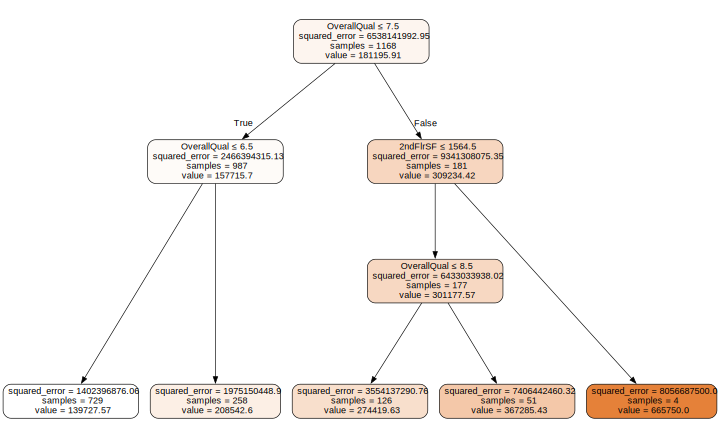

In [289]:
xs, y = tabular_data.train.xs, tabular_data.train.y # The independent and dependent params
valid_xs, valid_y = tabular_data.valid.xs, tabular_data.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=5)
m.fit(xs, y)

draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [ ]:
dtreeviz.model(m,
               X_train=xs, y_train=y,
               feature_names=list(xs.columns),
               target_name='Sale Price').view()

Create a decision tree with more nodes. We shouldn't have as many nodes as we can as this will overfit the data.

In [290]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)

DecisionTreeRegressor(min_samples_leaf=25)

I'm adding the log here in the `r_mse` function instead of in the data itself. I'm unsure if this is correct but the submission sample suggests the result should just be the predicted price, not the log of it.

In [265]:
def r_mse(prediction, y): return round(math.sqrt(((np.log(prediction) - np.log(y) ) ** 2).mean()), 6)
def m_rmse(model, xs, y): return r_mse(model.predict(xs), y)    

In [294]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)
# What are these numbers, what is the kind of scale I should be thinking about
# What is a good rmse? The part that's confusing me is the book say 0.331466 is bad but 
# 0.323396 is good.
# In any case (0.165274, 0.197932) looks pretty good.

(0.162517, 0.176878)

## Submit first attempt
Take a look at the submission sample to see what we need. A CSV of ID and sale price

In [304]:
sub_sample = pd.read_csv(path/'sample_submission.csv')
sub_sample

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [295]:
test_data.train

        Id  MSSubClass  MSZoning  LotFrontage  ...  saleIs_quarter_start   
0     1461          20         3         80.0  ...                     1  \
1     1462          20         4         81.0  ...                     1   
2     1463          60         4         74.0  ...                     1   
3     1464          60         4         78.0  ...                     1   
4     1465         120         4         43.0  ...                     2   
...    ...         ...       ...          ...  ...                   ...   
1454  2915         160         5         21.0  ...                     1   
1455  2916         160         5         21.0  ...                     2   
1456  2917          20         4        160.0  ...                     1   
1457  2918          85         4         62.0  ...                     2   
1458  2919          60         4         74.0  ...                     1   

      saleIs_year_end  saleIs_year_start   saleElapsed  
0                   1         

In [299]:
preds = m.predict(test_data.xs)
len(preds)

1459

In [303]:
# Zip up the ids and predictions, then transform to 2D array from Array of tuples
submission = [list(t) for t in list(zip(test_data['Id'], preds))]

# Convert to Pandas dataframe to output CSV for submission.
sub_df = pd.DataFrame(submission, columns=['Id', 'SalePrice'])
sub_df.to_csv('subm.csv', index=False)
!head subm.csv

Id,SalePrice
1461,135208.0
1462,143792.39130434784
1463,167683.6052631579
1464,178300.5945945946
1465,229906.02083333334
1466,178300.5945945946
1467,168913.975
1468,178300.5945945946
1469,170115.6


In [305]:
from kaggle import api
api.competition_submit_cli('subm.csv', 'Initial decision tree', comp)

100%|██████████████████████████████████████████████████████████████████████████| 28.6k/28.6k [00:00<00:00, 39.5kB/s]


Successfully submitted to House Prices - Advanced Regression Techniques